#### Imports

In [1]:
import math
import nltk
import scipy.sparse
import numpy as np
import sklearn
import sklearn.decomposition
import matplotlib.pyplot as plt

### ZAD 1 - Wyszukiwarka

##### Celem zadania było zbudowanie przeglądarki, której bazą są zebrane w pliku tekstowym artykuły, w moim przypadku "simple wikipedia", (https://github.com/LGDoor/Dump-of-Simple-English-Wiki)

##### Plik z danymi był parsowaniy poniższą funkcją, gdzie poszczególne części artykułów były rozdzielane funkcją split.

In [2]:
def get_words_and_articles(file):
    f = open(file)
    for article in f.read().split('\n\n'):
        name, content = article.split('\n', 1)
        yield name, content


##### W kolejnym kroku, rozdzielone artykuły były tokenizowane, funkcją z biblioteki nltk, word_tokenize, obcinane to formy podstawowej funkcją PorterStemmer.stem(), oraz jeśli spełniły warunki (Warunki: 1.Słowo musi być dłuższe niż 2 znaki, 2. słowo musi być alfanumeryczne, 3. słowo nie może znajdować się w zbiorze angielskich stopwords), takie słowo/token dodawany jest do zbioru tokenów, który w następnej kolejności zamieniany jest na słownik termów do indekśów oraz indeksów do termów. 

##### W następnej kolejności, częstości występowania poszczególnych termów przepisywane są do rzadkiej macierzy oraz normalizowane aby uprościć obliczenia w kolejnych krokach.

##### Funkcja zwraca: potrzebne do dalszych obliczeń, macierz termów i artykułów, słownik termów do indeksów, liste artykułów, słownik indeksów do termów oraz zbiór termów/tokenów

In [3]:
tokenizer = nltk.word_tokenize
stemmer = nltk.stem.PorterStemmer()
stop_words = nltk.corpus.stopwords.words('english')

In [4]:
def save_matrix():
    art_dest = './articles/corpus.txt'

    w = get_words_and_articles(art_dest)
    w2 = get_words_and_articles(art_dest)

    tokens = set()
    articles = dict()

    percentage = 0

    print("TOKENIZING...")
    a_count = len(list(w2))
    for i, word in enumerate(w):
        articles[i] = word
        if (i / a_count) * 100 > percentage:
            print("PROGRESS: ", percentage, "%")
            percentage += 5
        for token in tokenizer(word[1]):
            token = stemmer.stem(token)
            if len(token) > 2 and token.isalnum() and not token.isdigit() and token not in stop_words:
                tokens.add(token)

    terms = dict()
    term_to_ind = dict()
    for i, token in enumerate(tokens):
        terms[i] = token
        term_to_ind[token] = i

    term_by_doc = scipy.sparse.lil_matrix((len(terms), len(articles)))

    percentage = 0
    a_count = len(articles)
    print("COUNTING...")
    for i in range(len(articles)):
        if (i / a_count) * 100 > percentage:
            print("PROGRESS: ", percentage, "%")
            percentage += 5
        for token in tokenizer(articles[i][1]):
            ter = stemmer.stem(token)
            if ter in term_to_ind:
                term_by_doc[term_to_ind[ter], i] += 1

    count = scipy.sparse.linalg.norm(term_by_doc, ord=0, axis=1)
    idf = np.log(float(len(articles)) * np.reciprocal(count, dtype=np.float64))

    term_by_doc = term_by_doc.T.multiply(idf).T

    term_by_doc = sklearn.preprocessing.normalize(term_by_doc, axis=0, norm='l2', copy=False)

    return term_by_doc, terms, articles, term_to_ind, tokens

##### Taka macierz może być następnie zapisana w postaci macierzy svd

In [5]:
def save_as_svd(matrix, k):
    svd = sklearn.decomposition.TruncatedSVD(k).fit(matrix.T)
    res_matrix = svd.transform(matrix.T)
    comps = svd.components_

    return res_matrix, comps

##### Wprowadzone zapytania przekształcane są do wektorów poprzez zliczanie ilości występujących w zbiorze termów, termów z zapytania oraz wstawieniu w ich miejscu 1/sqrt(len(vector)), aby wektor był znormalizowany, co upraszcza dalsze obliczenia.

In [6]:
def query_to_vector(q, terms, term_to_ind, tokens):

    term_set = set()
    vec = scipy.sparse.lil_matrix((len(terms), 1))
    for token in tokenizer(q):
        comparable = stemmer.stem(token)
        if comparable in tokens:
            term_set.add(comparable)

    if len(term_set) == 0:
        return None
    value = 1.0 / math.sqrt(len(term_set))
    for tok in term_set:
        vec[term_to_ind[tok], 0] = value

    return vec

##### Jeżeli posiadamy już potrzebne komponenty, to obliczamy korelacje wszystkich wektorów artykułów oraz wektora zapytania, następnie są sortowane, wypisywanie oraz wyswietlany jest wykres koralacji.

In [15]:
def search_query(q, is_svd=False, matrix_tools=None, svd_tools=None, k=1000, minimal_corr=0.2):
    if matrix_tools is None:
        term_by_doc, terms, articles, term_to_ind, tokens = save_matrix()
    else:
        term_by_doc, terms, articles, term_to_ind, tokens = matrix_tools

    if is_svd and svd_tools is None:
        svd_tools = save_as_svd(term_by_doc, k)
    if is_svd:
        matrix, comp = svd_tools

    query = q
    q_vec = query_to_vector(query, terms, term_to_ind, tokens)
    if q_vec is None:
        print("")
        print("Could not find such thing")
        print("")
        return None

    if is_svd:
        q_form = comp.dot(q_vec.todense())
        cor_svd = matrix.dot(q_form)
        corr = [((0, ind), cor_svd[ind, 0]) for ind in range(len(articles))]
    else:
        corr = list(q_vec.T.dot(term_by_doc).todok().items())
    corr.sort(key=lambda x: -x[1])
    res_list = []
    for el in corr:
        if el[1] > minimal_corr:
            print("-------------------------------------------------------------------")
            print(" ")
            print(articles[el[0][1]][0])
            print(articles[el[0][1]][1])
            print(" ")
            res_list.append((articles[el[0][1]][0], articles[el[0][1]][1]))
        else:
            break

    plot_corr_vector(corr, minimal_corr)
    return res_list

In [16]:
def plot_corr_vector(v, minimal_corr):
    x = [i for i in range(len(v))]
    y = [el[1] for el in v]
    y2 = [minimal_corr for xi in x]
    plt.plot(x, y, 'bo', x, y2, 'r-')
    plt.show()

In [17]:
matrix_tools = save_matrix()

TOKENIZING...
PROGRESS:  0 %
PROGRESS:  5 %
PROGRESS:  10 %
PROGRESS:  15 %
PROGRESS:  20 %
PROGRESS:  25 %
PROGRESS:  30 %
PROGRESS:  35 %
PROGRESS:  40 %
PROGRESS:  45 %
PROGRESS:  50 %
PROGRESS:  55 %
PROGRESS:  60 %
PROGRESS:  65 %
PROGRESS:  70 %
PROGRESS:  75 %
PROGRESS:  80 %
PROGRESS:  85 %
PROGRESS:  90 %
PROGRESS:  95 %
COUNTING...
PROGRESS:  0 %
PROGRESS:  5 %
PROGRESS:  10 %
PROGRESS:  15 %
PROGRESS:  20 %
PROGRESS:  25 %
PROGRESS:  30 %
PROGRESS:  35 %
PROGRESS:  40 %
PROGRESS:  45 %
PROGRESS:  50 %
PROGRESS:  55 %
PROGRESS:  60 %
PROGRESS:  65 %
PROGRESS:  70 %
PROGRESS:  75 %
PROGRESS:  80 %
PROGRESS:  85 %
PROGRESS:  90 %
PROGRESS:  95 %


-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

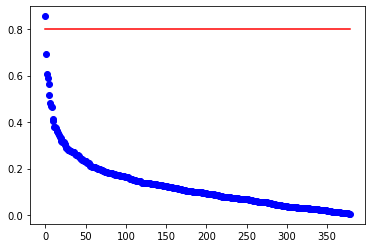

In [19]:
query = 'flower'
_ = search_query(query, matrix_tools=matrix_tools, minimal_corr=0.8)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

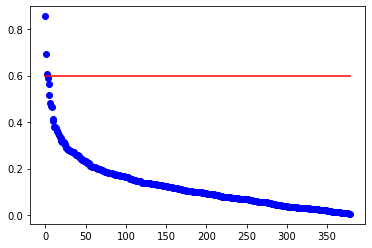

In [20]:
query = 'flower'
_ = search_query(query, matrix_tools=matrix_tools, minimal_corr=0.6)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

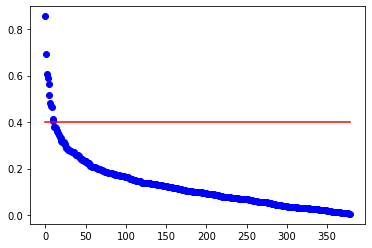

In [21]:
query = 'flower'
_ = search_query(query, matrix_tools=matrix_tools, minimal_corr=0.4)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

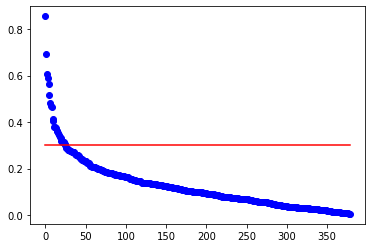

In [22]:
query = 'flower'
_ = search_query(query, matrix_tools=matrix_tools, minimal_corr=0.3)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

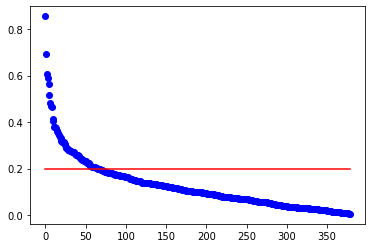

In [23]:
query = 'flower'
_ = search_query(query, matrix_tools=matrix_tools, minimal_corr=0.2)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

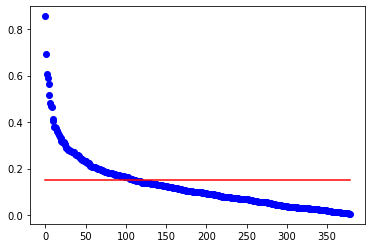

In [24]:
query = 'flower'
_ = search_query(query, matrix_tools=matrix_tools, minimal_corr=0.15)

##### Z powyższych testów ustaliłem, że dla przykładowego zapytania dla minimalnej korelacji 0.2 funkcja zwraca zbliżone do zapytania artykuły natomiast dla niższych artykuł stają się mniej powiązane

In [28]:
svd_s = save_as_svd(matrix_tools[0], k=10)

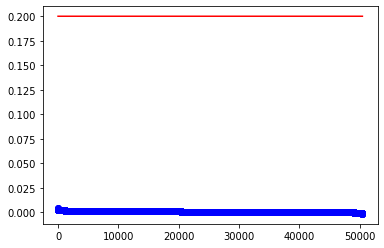

In [29]:
query = 'flower'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=10)

In [26]:
svd_s = save_as_svd(matrix_tools[0], k=100)

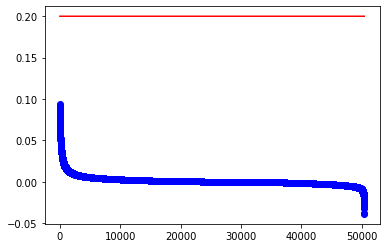

In [27]:
query = 'flower'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=100)

In [30]:
svd_s = save_as_svd(matrix_tools[0], k=300)

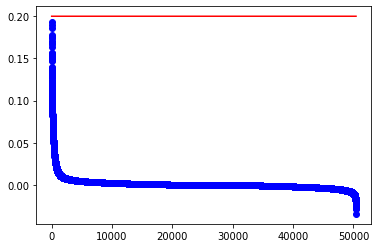

In [31]:
query = 'flower'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=300)

In [32]:
svd_s = save_as_svd(matrix_tools[0], k=400)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

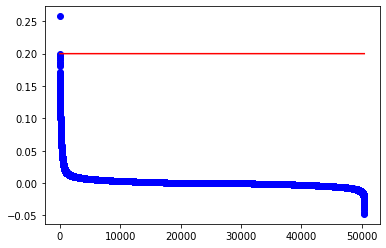

In [33]:
query = 'flower'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=400)

In [35]:
svd_s = save_as_svd(matrix_tools[0], k=500)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

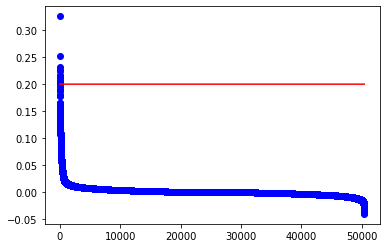

In [36]:
query = 'flower'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=400)

In [37]:
svd_s = save_as_svd(matrix_tools[0], k=500)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

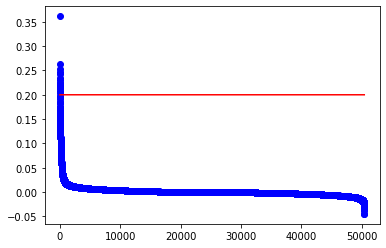

In [38]:
query = 'flower'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=500)

In [40]:
svd_s = save_as_svd(matrix_tools[0], k=1000)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

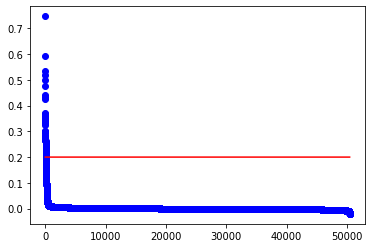

In [41]:
query = 'flower'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=1000)

-------------------------------------------------------------------
 
Flower
A flower is a part of a plant. Flowers are also called the bloom or blossom of a plant. It sometimes has a stem - a thin pipe - to support the flower. Flowers have petals. The word "flower" is usually used only for the part that produces seeds.
In many plants, a flower is its most colourful part. We say the plant 'flowers', 'is flowering' or 'is in flower' when this colourful part begins to grow bigger and open out.
There are many different kinds of flowers in different areas in the world. Even in the coldest places, for example the Arctic, flowers can grow during a few months.
the reproductive structure found in flowering plants (plants of the division Magnoliophyta, also called angiosperms).
For plants.
Flowers contains the reproductive organs of a plant. Many flowers are dependent upon the wind to move pollen between flowers of the same species. Other plants rely on insects or bees to move pollen. The role 

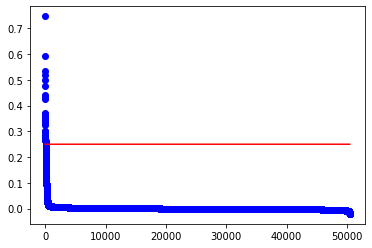

In [44]:
query = 'flower'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=1000, minimal_corr=0.25)

##### SVD dla k = 500, działa akcptowalnie, jednak jeśli zwiększymy k do 1000 oraz podniesiemy minimalną korelacje to wyniki wyraźnie poprawiają się

-------------------------------------------------------------------
 
CSU
Any of the following universities or university systems
 
-------------------------------------------------------------------
 
University of Illinois at Urbana-Champaign
The University of Illinois at Urbana-Champaign (UIUC) is a university in the state of Illinois, United States. It is the oldest and largest campus in the University of Illinois system.
The university has 18 Colleges that offer more than 150 programs of study. It is a selective state schools in the United States. Many of its popular undergraduate and graduate programs are ranked high in the US.
History.
The university was established in 1867. It opened for classes on March 2, 1868 with only two faculty members and a small group of students. In 1982, the name of the university was changed to the University of Illinois at Urbana-Champaign.
Notable alumni and faculty.
Notable people associated with the university have been successful in fields such 

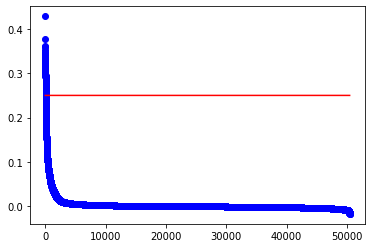

In [45]:
query = 'agh university of science and technology'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=1000, minimal_corr=0.25)

-------------------------------------------------------------------
 
CSU
Any of the following universities or university systems
 
-------------------------------------------------------------------
 
University of Illinois at Urbana-Champaign
The University of Illinois at Urbana-Champaign (UIUC) is a university in the state of Illinois, United States. It is the oldest and largest campus in the University of Illinois system.
The university has 18 Colleges that offer more than 150 programs of study. It is a selective state schools in the United States. Many of its popular undergraduate and graduate programs are ranked high in the US.
History.
The university was established in 1867. It opened for classes on March 2, 1868 with only two faculty members and a small group of students. In 1982, the name of the university was changed to the University of Illinois at Urbana-Champaign.
Notable alumni and faculty.
Notable people associated with the university have been successful in fields such 

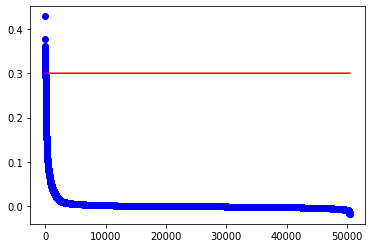

In [48]:
query = 'agh university of science and technology'
_ = search_query(query, is_svd=True, matrix_tools=matrix_tools, svd_tools=svd_s, k=1000, minimal_corr=0.3)

##### Z dalszych testów wynika, że dla zapytań dłuższych niż jedno słowo wymagana jest większa precyzja (minimalna korelacja)

-------------------------------------------------------------------
 
Science Olympiad
The Science Olympiad is a nation-wide event in the United States that tests students' knowledge in science and technology. It started in 1982, and takes place every year.
 
-------------------------------------------------------------------
 
CSU
Any of the following universities or university systems
 
-------------------------------------------------------------------
 
Illinois Institute of Technology
The Illinois Institute of Technology (IIT) is a private university in Chicago, Illinois, United States. It is one of the best universities in the United States. U.S. News & World Report, a magazine, puts it at number 97. Most students of this university focus on science or technology as their major, or subject they study most. IIT was created in 1940.
 
-------------------------------------------------------------------
 
Cambridge Science Park
The Cambridge Science Park was started by Trinity Colleg

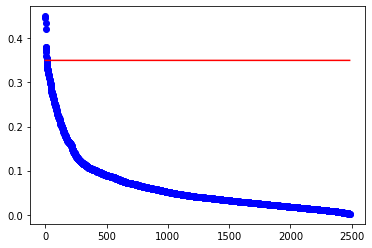

In [51]:
query = 'agh university of science and technology'
_ = search_query(query, matrix_tools=matrix_tools, svd_tools=svd_s, k=1000, minimal_corr=0.35)

###     WNIOSKI

##### - Usuwanie szumów ma duże znaczenie dla uzyskiwanych odpowiedzi, szczególnie gdy szukana fraza składa się z większej ilości słów
##### - Z testów wynika, że minimalna korelacja, zarówn z svd jak i bez plasuje się w przedziale pomiędzy 0.2 a 0.4, w zależności od zapytania
##### - Wraz ze wzrostem k dla svd rosnie precyzja uzyskiwanych rozwiązań, natomiast niesie to ze sobą większe koszty oblicznieowe
##### - Normalizacja wektorów i macierzy, przed obliczeniami znacznie ułatwia oraz przyspiesza obliczenia